In [ ]:
import keras
keras.__version__

'3.5.0'

In [ ]:
from keras import models
from keras import layers
from keras import metrics
from keras import optimizers

import numpy as np
import json
import os
import csv
import pandas as pd
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the data
ur_path = '/content/drive/MyDrive/FYP/LSTM Dataset/UR_Dataset/ur_data.csv'
mc_fall_path = '/content/drive/MyDrive/FYP/LSTM Dataset/MC_Dataset/mc_fall_data.csv'
mc_notfall_path = '/content/drive/MyDrive/FYP/LSTM Dataset/MC_Dataset/mc_notfall_data.csv'
youtube_fall_path = '/content/drive/MyDrive/FYP/LSTM Dataset/Youtube_Dateset/youtube_fall_data.csv'
youtube_notfall_path = '/content/drive/MyDrive/FYP/LSTM Dataset/Youtube_Dateset/youtube_notfall_data.csv'

In [ ]:
# Read the data
def read_data(path):
  video_data = []
  with open(path, mode='r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      video_data.append(row)
  return video_data

ur_data = read_data(ur_path)
mc_fall_data = read_data(mc_fall_path)
mc_notfall_data = read_data(mc_notfall_path)
youtube_fall_data = read_data(youtube_fall_path)
youtube_notfall_data = read_data(youtube_notfall_path)

print(ur_data[0])
print(mc_fall_data[0])
print(mc_notfall_data[0])
print(youtube_fall_data[0])
print(youtube_notfall_data[0])

['520.972', '128.178', '0.833728', '544.571', '130.782', '0.739747', '540.636', '132.754', '0.726633', '553.086', '154.999', '0.800764', '541.285', '166.155', '0.742877', '549.144', '129.467', '0.745059', '572.703', '155.035', '0.841464', '543.266', '171.369', '0.817947', '572.067', '169.415', '0.607432', '564.874', '166.16', '0.534525', '526.875', '181.191', '0.862423', '554.389', '217.851', '0.612664', '577.962', '170.732', '0.619415', '535.402', '188.398', '0.760066', '560.284', '220.479', '0.65847', '545.882', '232.266', '0.604373', '553.078', '232.915', '0.532739', '566.184', '222.453', '0.655722', '541.939', '229.002', '0.399536', '541.943', '227.687', '0.344383', '560.285', '217.223', '0.153482', 'fall-16-cam0_000000000016_keypoints']
['504.171', '238.019', '0.119379', '481.995', '237.979', '0.647555', '471.564', '247.106', '0.6547', '485.918', '299.334', '0.780827', '525.04', '307.158', '0.770417', '495.036', '228.845', '0.474206', '519.863', '220.995', '0.283234', '539.41', '2

In [ ]:
# Normalized the data
def normalize(list, width, height):
  for record in list:
    for i in range(0, 63, 3):
        record[i] = float(record[i])/ width
        record[i + 1] = float(record[i + 1]) / height

normalize(ur_data, 640, 240)
normalize(mc_fall_data, 720, 480)
normalize(mc_notfall_data, 720, 480)
normalize(youtube_fall_data, 640, 360)
normalize(youtube_notfall_data, 640, 360)

print(ur_data[0])
print(mc_fall_data[0])
print(mc_notfall_data[0])
print(youtube_fall_data[0])
print(youtube_notfall_data[0])

[0.81401875, 0.534075, '0.833728', 0.8508921875000001, 0.544925, '0.739747', 0.8447437499999999, 0.5531416666666666, '0.726633', 0.864196875, 0.6458291666666667, '0.800764', 0.8457578124999999, 0.6923125, '0.742877', 0.8580375, 0.5394458333333334, '0.745059', 0.8948484375, 0.6459791666666667, '0.841464', 0.848853125, 0.7140375, '0.817947', 0.8938546875, 0.7058958333333333, '0.607432', 0.882615625, 0.6923333333333334, '0.534525', 0.8232421875, 0.7549625, '0.862423', 0.8662328125000001, 0.9077125, '0.612664', 0.903065625, 0.7113833333333334, '0.619415', 0.8365656250000001, 0.7849916666666666, '0.760066', 0.87544375, 0.9186625, '0.65847', 0.8529406249999999, 0.9677749999999999, '0.604373', 0.864184375, 0.9704791666666667, '0.532739', 0.8846624999999999, 0.9268875, '0.655722', 0.8467796875, 0.954175, '0.399536', 0.8467859375, 0.9486958333333334, '0.344383', 0.8754453124999999, 0.9050958333333334, '0.153482', 'fall-16-cam0_000000000016_keypoints']
[0.7002375, 0.49587291666666666, '0.119379'

In [ ]:
# Check the target label in the UR Dataset
# -1 = not lying; 0 = falling; 1 = lying

target = []

path1 = '/content/drive/MyDrive/FYP/LSTM Dataset/Target/urfall-cam0-falls.csv'
path2 = '/content/drive/MyDrive/FYP/LSTM Dataset/Target/urfall-cam0-adls.csv'

def input_fall(path):
  with open(path, mode='r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      record = []
      record.append(row[0])
      record.append(row[1])
      label = row[2]
      if label == '1' or label == '0':
        record.append(1)
      else:
        record.append(0)
      # each record: [, , label], eg: ['fall-17', '22', 0]
      target.append(record)

# though laying in the video, but it is not fall, so I mark 0 as label
def input_adl(path):
  with open(path, mode='r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      record = []
      record.append(row[0])
      record.append(row[1])
      record.append(0)
      target.append(record)

input_fall(path1)
print("Falls of UR dataset:", len(target))

input_adl(path2)

df = pd.DataFrame.from_records(target)
df.to_csv (r'/content/drive/My Drive/FYP/LSTM Dataset/Target/target_data.csv', index = False, header=False)

Falls of UR dataset: 2995


In [ ]:
# Create a dictionary for target of UR Dataset

target_csv_path = '/content/drive/MyDrive/FYP/LSTM Dataset/Target/target_data.csv'

idx = 0
idx_dict = {}

with open(target_csv_path, mode='r') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    # Check each row: [, , label], such as: ['fall-17', '22', 0]
    idx_dict['.'.join(row[:2])] = idx  # {'fall-17.22' : 112}
    idx += 1

In [ ]:
# Match body landmark data with labelled UR dataset

bodylandmark = []
label = []
frame_name = []

for landmark in ur_data:
  video_name = landmark[-1].split("_") # as named as "fall-01-cam0_000000000001"
  video_name_split = video_name[0].split("-") # spliting "fall-01-cam0" into ["fall", "01", "cam0"]
  video_type = video_name_split[0] # "fall"
  video_id = video_name_split[1] # "01"
  frame_id = str(int(video_name[1])) # "000000000001" -> "1"

  try:
    video_name_split = '.'.join([video_id, frame_id])
    video_type_name_split = '-'.join([video_type,  video_name_split])
    label.append(target[idx_dict[video_type_name_split]][-1])

    # Convert str -> float
    body_lm = landmark[:-1]
    body_lm = list(map(float,body_lm))
    bodylandmark.append(body_lm)
    frameName = landmark[-1]
    frame_name.append(frameName)

  except:
    continue


# print("Bodylandmark Record Sample of UR Dataset:" )
# print(bodylandmark[0])
# print("Bodylandmark of UR Dataset: ", len(bodylandmark))
# print("Label of UR Dataset: ", len(label))

In [ ]:
# Add MC Dataset to the whole dataset
# 1 = fall; 0 = not fall

for record in mc_fall_data:
  body_lm = record[:-1]
  body_lm = list(map(float,body_lm))
  bodylandmark.append(body_lm)

  label.append(1) # 1 = Fall
  frameName = landmark[-1]
  frame_name.append(frameName)

for record in mc_notfall_data:
  body_lm = record[:-1]
  body_lm = list(map(float,body_lm))
  bodylandmark.append(body_lm)

  label.append(0) # 0 = Not fall
  frameName = landmark[-1]
  frame_name.append(frameName)

# print("Bodylandmark Record Sample of MC Dataset:" )
# print("Bodylandmark of MC Dataset: ", len(bodylandmark))
# print("Label of MC Dataset: ", len(label))

In [ ]:
# Add Youtube Dataset to the whole dataset
# 1 = fall; 0 = not fall

for record in youtube_fall_data:
  body_lm = record[:-1]
  body_lm = list(map(float,body_lm))
  bodylandmark.append(body_lm)

  label.append(1) # 1 = Fall
  frameName = landmark[-1]
  frame_name.append(frameName)

for record in youtube_notfall_data:
  body_lm = record[:-1]
  body_lm = list(map(float,body_lm))
  bodylandmark.append(body_lm)

  label.append(0) # 0 = Not fall
  frameName = landmark[-1]
  frame_name.append(frameName)

# print("Bodylandmark Record Sample of Youtube Dataset:" )
# print("Bodylandmark of Youtube Dataset: ", len(bodylandmark))
# print("Label of Youtube Dataset: ", len(label))

In [ ]:
# Change body landmark & label to the same data frame
all_data = []

for i in range(len(bodylandmark)):
  all_data.append([label[i]])
  all_data[i] = all_data[i] + bodylandmark[i]

In [ ]:
# Count the number of "Fall" and "Not fall" in Label

fall = label.count(1)
not_fall = label.count(0)

print("Number of Fall:", fall)
print("Number of Not fall:", not_fall)
print("Number of All Data:", len(label))

Number of Fall: 13128
Number of Not fall: 22151
Number of All Data: 35279


In [ ]:
# Split data into training dataset and validation dataset
# Divided into 6:4

np.random.shuffle(all_data)
split_pt = len(all_data) // 10 * 6

train_data = all_data[:split_pt]
valid_data = all_data[split_pt:]

print("Number of Training Data:", len(train_data))
print("Number of Validation Data:", len(valid_data))

# Check if all data has been split
print((len(train_data)+len(valid_data)) == len(label))

Number of Training Data: 21162
Number of Validation Data: 14117
True


In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from numpy import array

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * np.exp(0.1 * (10 - epoch))

x_train = []
y_train = []

for record in train_data:
  x_train.append(record[1:])
  label = int(record[0])
  y_train.append(label)

In [ ]:
def train_lstm_model(x_train, y_train):
  x_train = array(x_train)
  x_train = x_train.reshape((len(x_train), 1, len(x_train[0])))

  y_train = array(y_train)

  lstm_model = Sequential()
  lstm_model.add(LSTM(16,
                input_shape=(1, 63),
                return_sequences=True))
  lstm_model.add(LSTM(16, ))
  lstm_model.add(layers.Dense(1, activation='sigmoid'))
  lstm_model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc',
                        metrics.AUC(),
                        metrics.FalseNegatives(),
                        metrics.Recall(),
                        metrics.Precision(),
                        metrics.FalseNegatives(),
                        metrics.TrueNegatives(),
                        metrics.FalsePositives(),
                        metrics.TruePositives()])

  lstm_history = lstm_model.fit(x_train, y_train,
                      epochs=100,
                      batch_size=16,
                      validation_split=0.2,
                      callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5),
                      callbacks.LearningRateScheduler(scheduler)])

  print("Finish Training LSTM Model")
  return lstm_model, lstm_history

lstm_model, lstm_history = train_lstm_model(x_train, y_train)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1059/1059 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - acc: 0.7130 - auc: 0.7821 - false_negatives: 1322.0255 - false_negatives_1: 1322.0255 - false_positives: 927.1651 - loss: 0.5311 - precision: 0.6823 - recall: 0.4605 - true_negatives: 4411.4756 - true_positives: 1827.2905 - val_acc: 0.7912 - val_auc: 0.9133 - val_false_negatives: 74.0000 - val_false_negatives_1: 74.0000 - val_false_positives: 810.0000 - val_loss: 0.4086 - val_precision: 0.6510 - val_recall: 0.9533 - val_true_negatives: 1838.0000 - val_true_positives: 1511.0000 - learning_rate: 0.0010
Epoch 2/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - acc: 0.8322 - auc: 0.9184 - false_negatives: 421.2613 - false_negatives_1: 421.2613 - false_positives: 971.0821 - loss: 0.3509 - precision: 0.7344 - recall: 0.8658 - true_negatives: 4338.9170 - true_positives: 2756.6963 - val_acc: 0.7673 - val_auc: 0.8923 - val_false_negatives: 774.0000 - val_false_negatives_1: 774.0000 - val_false_positives: 211.0000 - val_loss: 0.5586 - val_precision: 0

In [ ]:
lstm_model.summary()
lstm_model.save("/content/drive/My Drive/FYP/LSTM/lstm_model.h5")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 16)               │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 16)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,500 (56.64 KB)

 Trainable params: 7,249 (28.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,251 (28.33 KB)

In [ ]:
import matplotlib.pyplot as plt

def plotting_training(history):

  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')
  plt.show()

  # Plot training & validation loss values
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.figure()
  plt.plot(epochs, loss, 'bo', label="Training loss")
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training & Validation loss')
  plt.xlabel('epoch', fontsize=10)
  plt.ylabel('loss', fontsize=10)
  plt.ylim(0.0,0.5)
  plt.legend()
  plt.show()

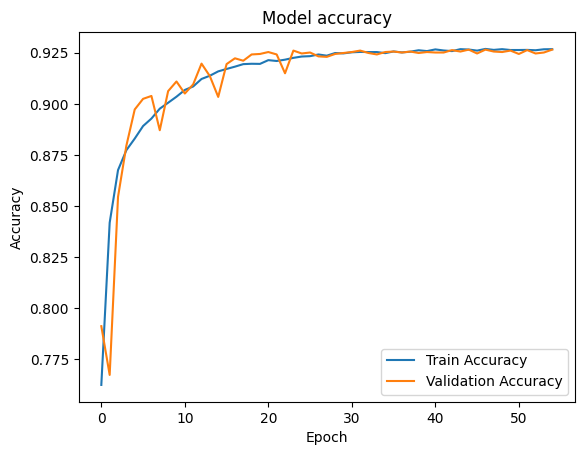

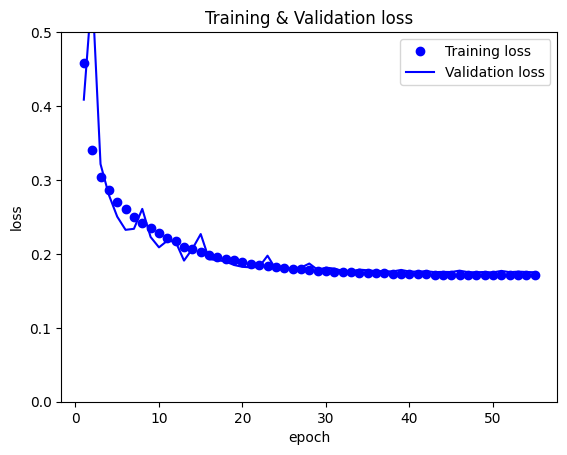

In [ ]:
plotting_training(lstm_history)